<a href="https://colab.research.google.com/github/21-Vaibhav/Real-time-chat/blob/main/HAN_model_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Import necessary libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, TimeDistributed, Dense, Layer, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report

In [11]:
# Load the dataset from Hugging Face
dataset = load_dataset("d0r1h/ILC")
df = pd.DataFrame(dataset['train'])

In [12]:
# Split the dataset into train and test sets
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)

# Tokenizer setup for word-level tokenization
MAX_WORDS = 10000
MAX_SENT_LEN = 30  # Max words per sentence
MAX_DOC_LEN = 50   # Max sentences per document

word_tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<UNK>")

# Custom sentence splitter using regex
def sentence_splitter(text):
    sentences = re.split(r'(?<=[.!? ])\s+', text.strip())
    return [sentence for sentence in sentences if sentence]

# Fit tokenizer on training cases
tokenized_cases = []
for case in train_data['Case']:
    sentences = sentence_splitter(case)
    tokenized_cases.append(" ".join(sentences))

word_tokenizer.fit_on_texts(tokenized_cases)

# Function to preprocess input into a fixed shape for HAN
def preprocess_han_input(text, max_sent_len, max_doc_len, tokenizer):
    sentences = sentence_splitter(text)
    tokenized_sentences = tokenizer.texts_to_sequences(sentences[:max_doc_len])
    padded_sentences = pad_sequences(tokenized_sentences, maxlen=max_sent_len, padding='post')

    if len(padded_sentences) < max_doc_len:
        padding = np.zeros((max_doc_len - len(padded_sentences), max_sent_len), dtype=np.int32)
        padded_sentences = np.vstack([padded_sentences, padding])

    return padded_sentences

# Prepare input and output for training
X_train = np.array([preprocess_han_input(case, MAX_SENT_LEN, MAX_DOC_LEN, word_tokenizer) for case in train_data['Case']])
y_train = np.array(train_data['Summary'])
X_test = np.array([preprocess_han_input(case, MAX_SENT_LEN, MAX_DOC_LEN, word_tokenizer) for case in test_data['Case']])
y_test = np.array(test_data['Summary'])

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, TimeDistributed, Dense, Dropout, Layer

# Define the Hierarchical Attention Network model
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Compute attention weights
        attention_weights = tf.nn.softmax(inputs, axis=1)
        # Compute context vector
        context_vector = tf.reduce_sum(attention_weights * inputs, axis=1)
        return context_vector

def create_han_model(max_words, max_sent_len, max_doc_len):
    input_layer = Input(shape=(max_doc_len, max_sent_len))
    embedding_layer = TimeDistributed(Embedding(input_dim=max_words, output_dim=128))(input_layer)

    # Bidirectional LSTM for sentence encoding
    lstm_layer = TimeDistributed(Bidirectional(LSTM(64, return_sequences=True)))(embedding_layer)

    # Apply attention mechanism
    attention_output = AttentionLayer()(lstm_layer)

    # Final LSTM layer
    lstm_output = Bidirectional(LSTM(64))(attention_output)

    # Output layer
    output_layer = Dense(1, activation='sigmoid')(lstm_output)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create the model
model = create_han_model(MAX_WORDS, MAX_SENT_LEN, MAX_DOC_LEN)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 50, 30)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_20                  │ (None, 50, 30, 128)         │       1,280,000 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_21                  │ (None, 50, 30, 128)         │          98,816 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,477,761 (5.64 MB)

 Trainable params: 1,477,761 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Example: Convert summaries to binary labels
# Assuming y_train and y_test are currently the summaries
# Create binary labels based on whether the summary is non-empty
y_train = np.array([1 if summary else 0 for summary in train_data['Summary']])
y_test = np.array([1 if summary else 0 for summary in test_data['Summary']])

# Ensure they are of type float32
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Check the shapes
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Now proceed with training the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
])

y_train shape: (1852,)
y_test shape: (206,)
Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 47s 331ms/step - accuracy: 0.9852 - loss: 0.1166 - val_accuracy: 1.0000 - val_loss: 2.0697e-05 - learning_rate: 0.0010
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 1.0000 - loss: 1.9138e-05 - val_accuracy: 1.0000 - val_loss: 1.4483e-05 - learning_rate: 0.0010
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step - accuracy: 1.0000 - loss: 1.3711e-05 - val_accuracy: 1.0000 - val_loss: 1.1007e-05 - learning_rate: 0.0010
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 181ms/step - accuracy: 1.0000 - loss: 1.0568e-05 - val_accuracy: 1.0000 - val_loss: 8.7071e-06 - learning_rate: 0.0010
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 184ms/step - accuracy: 1.0000 - loss: 8.4369e-06 - val_accuracy: 1.0000 - val_loss: 7.1309e-06 - learning_rate: 0.0010
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 192ms/step - accuracy: 1.0000 - loss: 6.9390e-06 - val_accuracy: 1.0000 - val_loss: 6.0064e-06 - learning_rate: 0

In [20]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 1.0000 - loss: 2.0431e-05
Test Loss: 2.0696636056527495e-05
Test Accuracy: 1.0


In [21]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Convert probabilities to binary labels (if binary classification)
predicted_labels = (predictions > 0.5).astype(int)  # Adjust threshold as needed

7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step


In [22]:
# Compare predicted labels with actual labels
for i in range(10):  # Display first 10 predictions
    print(f"Actual: {y_test[i]}, Predicted: {predicted_labels[i]}")

Actual: 1.0, Predicted: [1]
Actual: 1.0, Predicted: [1]
Actual: 1.0, Predicted: [1]
Actual: 1.0, Predicted: [1]
Actual: 1.0, Predicted: [1]
Actual: 1.0, Predicted: [1]
Actual: 1.0, Predicted: [1]
Actual: 1.0, Predicted: [1]
Actual: 1.0, Predicted: [1]
Actual: 1.0, Predicted: [1]


In [23]:
# Save the model
model.save('my_model.h5')

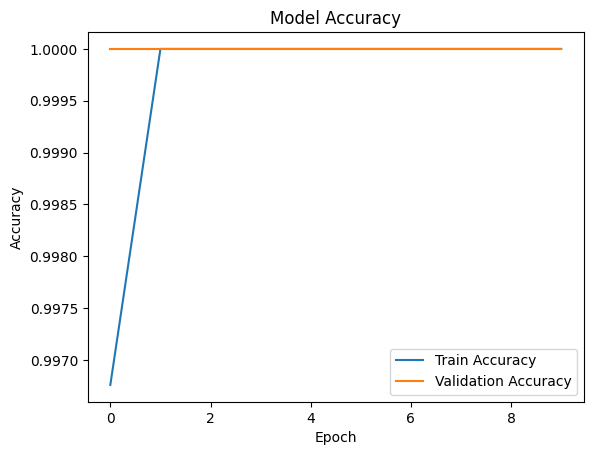

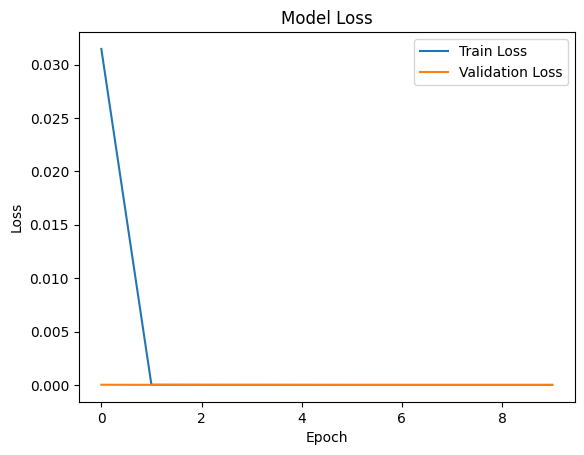

In [24]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable storing the training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()